BATTLE OF THE NEIGHBORHOODS: Exploring Suitable Locations for New Sushi Restaurants in Toronto, Canada using Data Science

This Capstone project work aims to utilize all Data Science Concepts learnt in the IBM Data Science Professional Course offered by Coursera.

In [1]:
# import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
!pip install bs4
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


Scraping the List of postal codes of Toronto, Canada

In [2]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text
soup = BeautifulSoup(source, 'html5lib')

In [3]:
table=soup.find('table')

In [4]:
#dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [5]:
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [6]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Data Cleaning: remove rows where Borough is 'Not assigned'

In [7]:
df=df[df['Borough']!='Not assigned']

In [8]:
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

In [10]:
df_merge = pd.merge(df, temp_df, on='Postalcode')

In [11]:
df_merge.drop(['Neighborhood'],axis=1,inplace=True)

In [12]:
df_merge.drop_duplicates(inplace=True)

In [13]:
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)

In [14]:
df_merge.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [15]:
df_merge.shape

(103, 3)

We have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [16]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [17]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')

In [18]:
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)

In [20]:
geo_df.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [21]:
geo_merged = pd.merge(geo_df, df_merge, on='Postalcode')

In [22]:
geo_data=geo_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]

In [23]:
geo_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [24]:
# lets find out how many neighborhoods in each borough
geo_data.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

Extracting Foursquare Data

In [25]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [26]:
CLIENT_ID = 'PAKQPX02V2D52KMHWDFYAKMXB3XWY4STTARD2MXBX1W5N2GK' # your Foursquare ID
CLIENT_SECRET = 'WKZ3VS3NCTRBOLYWQJ3J54IJYKD1DCION4UBBUYRUO11ANQL' # your Foursquare Secret
VERSION = '20180605'

In [27]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

In [29]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant


In [30]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,68,68,68,68,68,68
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37


In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


In [32]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Trail' 'Health Food Store' 'Pub' 'Neighborhood' 'Asian Restaurant'
 'Greek Restaurant' 'Cosmetics Shop' 'Ice Cream Shop' 'Italian Restaurant'
 'Brewery' 'Juice Bar' 'Yoga Studio' 'Fruit & Vegetable Store'
 'Restaurant' 'Pizza Place' 'Dessert Shop' 'Bookstore' 'Grocery Store'
 'Furniture / Home Store' 'Bubble Tea Shop' 'Spa' 'Caribbean Restaurant'
 'Coffee Shop' 'Bakery' 'Indian Restaurant' 'Café' 'American Restaurant'
 'Frozen Yogurt Shop' 'Lounge' 'Liquor Store' 'Sushi Restaurant' 'Gym'
 'Fish & Chips Shop' 'Fast Food Restaurant' 'Park' 'Pet Store'
 'Steakhouse' 'Burrito Place' 'Movie Theater' 'Sandwich Place'
 'Board Shop' 'Light Rail Station' 'Fish Market' 'Gay Bar'
 'Seafood Restaurant' 'Cheese Shop' 'Middle Eastern Restaurant'
 'Comfort Food Restaurant' 'Stationery Store' 'Wine Bar' 'Thai Restaurant'
 'Coworking Space' 'Bar' 'Latin American Restaurant' 'Gastropub'
 'Clothing Store' 'Gym / Fitness Center' 'Bank' 'Convenience Store'
 'Diner' 'Swim School' 

Sushi Restaurants present in the venues?

In [33]:
"Sushi Restaurant" in toronto_venues['Venue Category'].unique()

True

Analysis of Each Neighbourhood

In [34]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1648, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping of rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(39, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.066667,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.014706,0.0,0.0,0.014706,0.0,0.0,0.014706


Create a new dataframe to find Sushi Restaurants only

In [36]:
to_sushi = to_grouped[["Neighborhoods","Sushi Restaurant"]]

In [37]:
to_sushi.head()

,Neighborhoods,Sushi Restaurant
0,Berczy Park,0.017544
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.014706


In [38]:
to_sushi = to_sushi.rename(columns={'Neighborhoods':'Neighborhood'})

In [39]:
to_sushi.head()

,Neighborhood,Sushi Restaurant
0,Berczy Park,0.017544
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.014706


Clustering the Neighborhoods

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = to_sushi.drop(['Neighborhood'], axis=1)

In [41]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 0], dtype=int32)

In [42]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [43]:
scores = [get_inertia(x) for x in range(2, 21)]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab

Text(0, 0.5, 'Error')

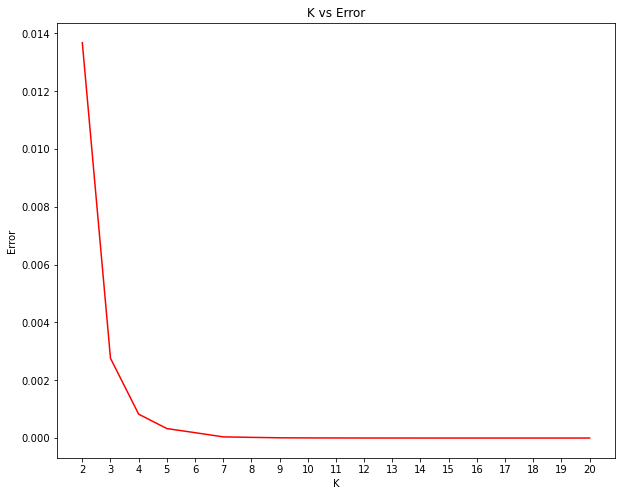

In [44]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


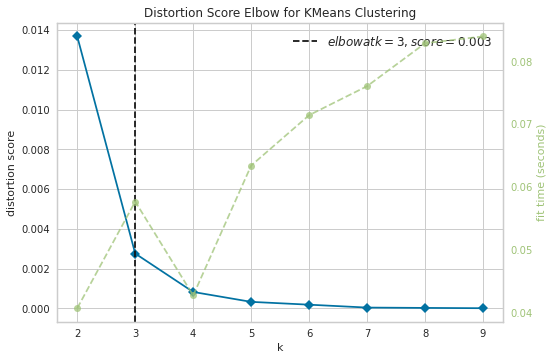

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
model = KMeans()
# Use the quick method and immediately show the figure
visualizer = kelbow_visualizer(KMeans(random_state=4), X, k=(2,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

It is observed that at K = 3, the distortion score is 0.003. Therefore 3 clusters are chosen for further analysis

In [46]:
kclusters = 3

toronto_grouped_clustering = to_sushi.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 0], dtype=int32)

In [47]:
# create a new dataframe that includes the cluster as well as the top venues for each neighborhood.
to_merged = to_sushi.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [48]:
to_merged.head()

,Neighborhood,Sushi Restaurant,Cluster Labels
0,Berczy Park,0.017544,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.014706,0


In [49]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1648, 9)


,Neighborhood,Sushi Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.017544,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.017544,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.017544,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.017544,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.017544,0,43.644771,-79.373306,Biff's Bistro,43.647085,-79.376342,French Restaurant


In [50]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(1648, 9)


,Neighborhood,Sushi Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.017544,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
25,"Richmond, Adelaide, King",0.020000,0,43.650571,-79.384568,Roy Thomson Hall,43.646589,-79.385979,Concert Hall
25,"Richmond, Adelaide, King",0.020000,0,43.650571,-79.384568,Kupfert & Kim (First Canadian Place),43.648547,-79.381624,Gluten-free Restaurant
25,"Richmond, Adelaide, King",0.020000,0,43.650571,-79.384568,Indigo,43.653515,-79.380696,Bookstore
25,"Richmond, Adelaide, King",0.020000,0,43.650571,-79.384568,Michael's on Simcoe,43.648269,-79.386328,Steakhouse
...,...,...,...,...,...,...,...,...,...
6,Church and Wellesley,0.051948,2,43.665860,-79.383160,The Drink,43.664167,-79.380149,Coffee Shop
6,Church and Wellesley,0.051948,2,43.665860,-79.383160,Town Inn Suites,43.669056,-79.382573,Hotel
6,Church and Wellesley,0.051948,2,43.665860,-79.383160,Bishop and Belcher,43.670096,-79.382354,Pub
6,Church and Wellesley,0.051948,2,43.665860,-79.383160,Coffee Island,43.664271,-79.386972,Coffee Shop


Number of Sushi Restaurants?

In [51]:
to_merged['Venue Category'].value_counts()['Sushi Restaurant']

25

There are a total of 25 locations with Sushi Restaurants in Toronto.

Visualization of Clusters

In [52]:
!pip install geopy
from geopy.geocoders import Nominatim
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [55]:
# save the map as HTML file
map_clusters.save('map_clusters1.html')

How many Neighborhoods per Cluster?

In [56]:
to_sushi["Cluster Labels"] = kmeans.labels_
to_sushi.head()

,Neighborhood,Sushi Restaurant,Cluster Labels
0,Berczy Park,0.017544,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.014706,0


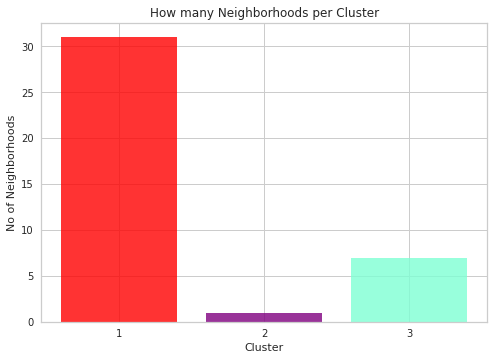

In [57]:
objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = to_sushi['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [58]:
# How many neighborhoods in each cluster
to_sushi['Cluster Labels'].value_counts()

0    31
2     7
1     1
Name: Cluster Labels, dtype: int64

Analysis of each Cluster

Cluster 1

In [59]:
# This will create a dataframe with borough of each neighborhood which will be merged with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
2,North York,Parkwoods
3,North York,Victoria Village
4,Downtown Toronto,"Regent Park, Harbourfront"
5,North York,"Lawrence Manor, Lawrence Heights"
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [60]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')

In [61]:
df_cluster1.sort_values(["Sushi Restaurant"], ascending=False)

,Borough,Neighborhood,Sushi Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
651,East Toronto,"The Danforth West, Riverdale",0.02381,0,43.679557,-79.352188,The Auld Spot Pub,43.677335,-79.353130,Pub
676,East Toronto,"The Danforth West, Riverdale",0.02381,0,43.679557,-79.352188,Marvel Coffee Co.,43.678630,-79.347460,Coffee Shop
668,East Toronto,"The Danforth West, Riverdale",0.02381,0,43.679557,-79.352188,Bar Oak,43.677931,-79.348724,Lounge
662,East Toronto,"The Danforth West, Riverdale",0.02381,0,43.679557,-79.352188,Simone's Caribbean Restaurant,43.678655,-79.346582,Caribbean Restaurant
670,East Toronto,"The Danforth West, Riverdale",0.02381,0,43.679557,-79.352188,Leonidas Chocolates Cafe,43.678118,-79.349485,Café
...,...,...,...,...,...,...,...,...,...,...
902,Downtown Toronto,"Commerce Court, Victoria Hotel",0.00000,0,43.648198,-79.379817,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
903,Downtown Toronto,"Commerce Court, Victoria Hotel",0.00000,0,43.648198,-79.379817,Ki Modern Japanese + Bar,43.647223,-79.379374,Japanese Restaurant
904,East Toronto,Studio District,0.00000,0,43.659526,-79.340923,McQueens Pub,43.661483,-79.338072,Gastropub
905,East Toronto,Studio District,0.00000,0,43.659526,-79.340923,Saulter Street Brewery,43.658412,-79.346392,Brewery


In [62]:
df_cluster1['Venue Category'].value_counts(ascending=False)['Sushi Restaurant']

12

Cluster 2

In [63]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')

In [64]:
df_cluster2.sort_values(["Sushi Restaurant"], ascending=False)

,Borough,Neighborhood,Sushi Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",0.2,1,43.696948,-79.411307,Oliver jewelry,43.700374,-79.407644,Jewelry Store
1,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",0.2,1,43.696948,-79.411307,Kay Gardner Beltline Trail,43.698446,-79.406873,Trail
2,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",0.2,1,43.696948,-79.411307,TTC Bus #14 Glencairn,43.700221,-79.410274,Bus Line
3,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",0.2,1,43.696948,-79.411307,Forest Hill Road Park,43.697945,-79.406605,Park
4,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",0.2,1,43.696948,-79.411307,Nikko Sushi Japenese Restaurant,43.700443,-79.407957,Sushi Restaurant


In [65]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Sushi Restaurant']

1

Cluster 3

In [66]:
# Aquamarine
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')

In [67]:
df_cluster3.sort_values(["Sushi Restaurant"], ascending=False)

,Borough,Neighborhood,Sushi Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
164,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.066667,2,43.686412,-79.400049,TTC Stop #,43.685826,-79.404981,Light Rail Station
169,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.066667,2,43.686412,-79.400049,Mary Be Kitchen,43.687708,-79.395062,Restaurant
159,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.066667,2,43.686412,-79.400049,Popeyes Louisiana Kitchen,43.689300,-79.395302,Fried Chicken Joint
160,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.066667,2,43.686412,-79.400049,Pizzaiolo,43.687991,-79.394634,Pizza Place
161,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.066667,2,43.686412,-79.400049,RBC Royal Bank,43.688058,-79.394478,Bank
...,...,...,...,...,...,...,...,...,...,...
94,Downtown Toronto,"University of Toronto, Harbord",0.030303,2,43.662696,-79.400049,Her Father's Cider Bar + Kitchen,43.662448,-79.404703,Beer Bar
93,Downtown Toronto,"University of Toronto, Harbord",0.030303,2,43.662696,-79.400049,Magic Noodle,43.662728,-79.403602,Noodle House
91,Downtown Toronto,"University of Toronto, Harbord",0.030303,2,43.662696,-79.400049,East of Brunswick,43.665609,-79.403324,Pub
88,Downtown Toronto,"University of Toronto, Harbord",0.030303,2,43.662696,-79.400049,Subway,43.664489,-79.399118,Sandwich Place


In [68]:
df_cluster3['Venue Category'].value_counts(ascending=False)['Sushi Restaurant']

12

Average Number of Sushi Restaurants per Cluster

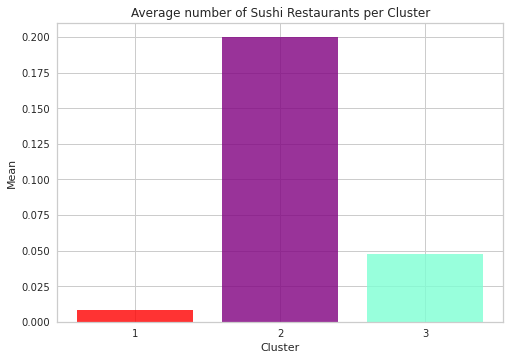

[0.008620689655172414, 0.2, 0.04780876494023904]

In [70]:
clusters_mean = [df_cluster1['Sushi Restaurant'].mean(),df_cluster2['Sushi Restaurant'].mean(),df_cluster3['Sushi Restaurant'].mean()]
objects = (1,2,3)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Sushi Restaurants per Cluster')

plt.show()
Avg = clusters_mean
Avg

Observations

1) Most of the Sushi Restaurants in Toronto are located in Cluster 2 represented by the color Purple. The neighborhoods in this cluster include Forest Hill North & West and Forest Hill Road Park in Central Toronto
So new Sushi restaurants in these areas will face tough competition and is not recommended.
2) The second highest Sushi Restaurants in Toronto are located in cluster 3 respresented by the color Aquamarine. 
The neighborhoods in this cluster include Summerhill West, Rathnelly, South Hill, etc in Central Toronto and University of Toronto and Harbord in Downtown Toronto. New Sushi restaurants in these areas can be started as there is less competition.
3) The least or no Sushi Restaurants are in Cluster 1 represented by the color Red. 
There are 31 neighborhoods in this cluster. 
New Sushi restaurants can be started in the neighborhoods of The Danforth West, Riverdale, Studio District, etc in East Toronto and Commerce Court & Victoria Hotel in Downtown Toronto.

Drawbacks:
1) The clustering is completely based on data obtained from the Foursquare API. 
2) Also, the analysis does not take into consideration of the Sushi patron population (primarily Asian) across the neighbourhoods.